   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

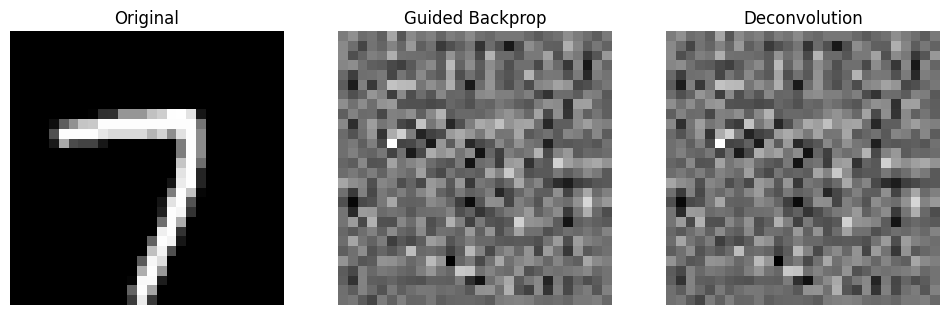

In [3]:
# Install dependencies
!pip install torch torchvision

# Import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load MNIST
transform = transforms.ToTensor()
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# Simple CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc = nn.Linear(7*7*32, 10)
        self.pool = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

# Dummy training (or skip for demo purposes)
model.eval()

# Get one image
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)
output = model(images)
pred = output.argmax(dim=1)

# Guided Backpropagation
def guided_backprop(model, image, target_class):
    image.requires_grad = True
    model.zero_grad()
    out = model(image)
    loss = out[0, target_class]
    loss.backward()

    return image.grad[0].cpu().detach().numpy()

# Deconvolution (only positive gradients)
def deconv(model, image, target_class):
    def hook_fn(module, grad_in, grad_out):
        return (torch.clamp(grad_in[0], min=0.0),)

    hooks = []
    for m in model.modules():
        if isinstance(m, nn.ReLU):
            hooks.append(m.register_full_backward_hook(hook_fn))

    image.requires_grad = True
    model.zero_grad()
    out = model(image)
    loss = out[0, target_class]
    loss.backward()

    for h in hooks:
        h.remove()

    return image.grad[0].cpu().detach().numpy()

# Visualize
gbp = guided_backprop(model, images.clone(), pred)
dec = deconv(model, images.clone(), pred)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(images[0,0].cpu(), cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(gbp[0], cmap='gray')
plt.title('Guided Backprop')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(dec[0], cmap='gray')
plt.title('Deconvolution')
plt.axis('off')

plt.show()
